In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from scipy.optimize import curve_fit
import matplotlib as mpl
import struct
import glob
import os 
import struct
from sklearn import linear_model
import scipy.linalg
hubble = 0.73

%matplotlib inline

In [2]:
def load_obs(obs_name):
    dtype=[('name','|S20'),
           ('x', 'f8'),
           ('y', 'f8'), 
           ('z', 'f8'),
           ('delta_plus', 'f8'),
           ('delta_minus', 'f8'),
           ('vmag', 'f8'),
           ('delta_vmag', 'f8')]
    obs_data = np.loadtxt(obs_name, dtype=dtype)    
    return obs_data

In [3]:
def main_halos(snap_data, sort_column='mstar', single_reverse=False):
    id_sorted = np.argsort(snap_data[sort_column])
    if single_reverse:
        id_halo_A = id_sorted[0]
        main_halos_data = snap_data[id_halo_A]
    else:
        id_halo_A = id_sorted[-1]
        id_halo_B = id_sorted[-2]
        main_halos_data = snap_data[[id_halo_A, id_halo_B]]
    return main_halos_data

In [15]:
def satellite_halos(halo_data, halo_center, vmax=None, max_points=10, sort_column='vmag'):
    jj = np.argsort(halo_data[sort_column])
    tmp_halo = halo_data[jj]
    if vmax is None:
        radius = halo_center['vmax']/(10.0 * 100) * 1000 * hubble# in kpc
    else:
        radius = vmax/(10.0 * 100) * 1000  * hubble # in kpc
    print('radius', radius)
    for col in list(['x','y','z']):
        tmp_halo[col] = tmp_halo[col] - halo_center[col]
    
    r = np.sqrt(tmp_halo['x']**2 + tmp_halo['y']**2 + tmp_halo['z']**2)
    ii = (r < radius) & (r>1E-6)
    
    tmp_halo = tmp_halo[ii]
    r = np.sqrt(tmp_halo['x']**2 + tmp_halo['y']**2 + tmp_halo['z']**2)
    return tmp_halo[:max_points], np.min(r[:max_points]), np.max(r[:max_points])

In [16]:
def inertiaTensor(x,y,z):
    I=[]
    for index in range(9):
        I.append(0)
   
    I[0] = np.sum(y*y+z*z) 
    I[1] = np.sum(-y*x)    
    I[2] = np.sum(-x*z)    
    I[3] = np.sum(-y*x)    
    I[4] = np.sum(x*x+z*z) 
    I[5] = np.sum(-y*z)    
    I[6] = np.sum(-z*x)    
    I[7] = np.sum(-z*y)    
    I[8] = np.sum(x*x+y*y) 
    tensor = np.array([(I[0:3]), (I[3:6]), (I[6:9])])
    vals, vects = np.linalg.eig(tensor)  # they come out unsorted, so the command below is needed
    eig_ord = np.argsort(vals)  # a thing to note is that here COLUMN i corrensponds to eigenvalue i.
    ord_vals = vals[eig_ord]
    ord_vects = vects[:, eig_ord].T

    return ord_vals, ord_vects[2]

In [17]:
def get_best_plane(pos_satellites, plotting=False, unit_vector=np.array([1.0,0.0,0.0])):
    """
    Input:
    pos_satellites: Numpy structured array with the satellites positions 
                    assuming that the halo centar is at 0.0,0.0,0.0.
    """
    
    #fit the best plane with a linear regresion, this will be used for a first guess
    regr = linear_model.LinearRegression()
    X_fit = np.array([pos_satellites[0,:], pos_satellites[1,:]])
    Y_fit = np.array(pos_satellites[2,:])
    regr.fit(X_fit.T, Y_fit.T)

    #create vectors defining the planes
    #print('n satellites {}'.format(np.shape(pos_satellites)))
    n_vectors = 10000
    costheta = (np.random.random(n_vectors)-0.5)*2.0
    theta = np.cos(costheta)
    phi = np.random.random(n_vectors) * 2.0 * np.pi
    unit_vectors = np.zeros((n_vectors,3))
    unit_vectors[:,0] = np.sin(theta) * np.cos(phi)
    unit_vectors[:,1] = np.sin(theta) * np.sin(phi)
    unit_vectors[:,2] = np.cos(theta)
    
    #replace the answer from the linear fit to be the first guess. This should be the right answer for 3 points!
    # i.e. we should get a plane of zero width for three points using this vector.
    unit_vectors[0,0] = regr.coef_[0]
    unit_vectors[0,1] = regr.coef_[1]
    unit_vectors[0,2] = -1.0
    unit_vectors[0,:] = unit_vectors[0,:]/(np.sqrt(np.sum(unit_vectors[0,:]**2)))
    
    
    # find distances of all points to all planes
    distances_to_planes = np.dot(unit_vectors, pos_satellites)
    percentiles = np.percentile(distances_to_planes, [16,50,84], axis=1)
    delta_plane = percentiles[2,:]-percentiles[0,:]
    
    # the best plane is the one with the minimum width
    i_min = np.argmin(delta_plane)
    
    #i_min = np.argmax(delta_plane)
    
    plane_delta = delta_plane[i_min]
    plane_center = percentiles[1,i_min]
    plane_vector = unit_vectors[i_min,:]
    
    if plotting:
        plt.scatter(delta_plane, percentiles[1,:], s = 0.1)
        #print(percentiles[:,i_min], distances_to_planes[i_min, :], pos_satellites)
    #print("plane vector", plane_vector)
    return plane_delta, plane_center, plane_vector

In [18]:
def gen_random_sphere(n_points):
    """
    Sets of points in the 3D sphere
    """
    r = np.random.random(n_points)**(1.0/3.0)
    phi = np.random.random(n_points) * 2.0 * np.pi
    costheta = 2.0*(np.random.random(n_points) -0.5)
    theta = np.arccos(costheta)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

In [19]:
def spherical_randomize(x_in, y_in, z_in):
    """
    Randomizes a set of points around the coordinates origin.
    """
    n_points = len(x_in)
    r = np.sqrt(x_in**2 + y_in**2 + z_in**2)
    phi = np.random.random(n_points) * 2.0 * np.pi
    costheta = 2.0*(np.random.random(n_points) -0.5)
    theta = np.arccos(costheta)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

In [20]:
def sample_plane_width(x_in, y_in, z_in , n_realizations=100):
    """
    Sample the best plane width for  different n_points
    """

    p_width_all = np.zeros(n_realizations)
    p_center_all = np.zeros(n_realizations)
    for i in range(n_realizations):
        x, y, z = spherical_randomize(x_in, y_in, z_in)
        pos = np.array([x,y,z])
        p_width_all[i], p_center_all[i] , q = get_best_plane(pos)
        

    return p_width_all.mean(), p_width_all.std(), p_center_all.mean(), p_center_all.std()

In [21]:
def write_inertia_and_planes(output_stream, satellite_data, center_data):
    # inertia tensor
    values, vec_a = inertiaTensor(satellite_data['x'], 
                                satellite_data['y'], 
                                satellite_data_A['z'])
    output_stream.write("{:.2e}  {:.2e}  {:.2e} ".format(values[0], values[1], values[2]))
    output_stream.write("{:.4f}  {:.4f}  {:.4f}\t ".format(vec_a[0], vec_a[1], vec_a[2]))

    # finding the best planes 
    plane_w, plane_c, plane_v = get_best_plane(np.array([satellite_data['x'],
                                                    satellite_data['y'],
                                                    satellite_data['z']]), plotting=True)
    output_stream.write("{:.2f} {:.2f} ".format(plane_w, plane_c))
    output_stream.write("{:.4f} {:.4f} {:.4f}\t".format(plane_v[0], plane_v[1], plane_v[2]))
    return

radius 160.6
radius 197.1
[(b'LMC', -1.0, -41.0, -27.0, 2.0, 2.0, -18.1, 0.1)
 (b'SMC', 16.0, -38.0, -45.0, 3.0, 4.0, -16.8, 0.2)
 (b'CanisMajor', -12.0, -6.0, -1.0, 1.0, 1.0, -14.4, 0.8)]
N bright: 3 3


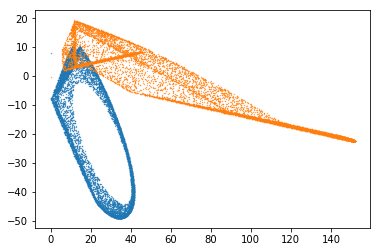

In [22]:
MW_data = load_obs("../data/obs/MW_satellites.txt")
M31_data = load_obs("../data/obs/M31_satellites.txt")

#change distance units to kpc/h
for l in ['x', 'y', 'z']:
    M31_data[l] = M31_data[l]
    MW_data[l] = MW_data[l]

MW = main_halos(MW_data, sort_column='vmag', single_reverse=True)
M31 = main_halos(M31_data, sort_column='vmag', single_reverse=True)

n_sat_max = 3
vmax_MW = 220.0
vmax_M31 = 270.0
m_star_M31 = 10.3
m_star_MW = 6.08
satellite_data_A, min_r_MW, max_r_MW = satellite_halos(MW_data, MW, vmax=vmax_MW, max_points=n_sat_max)
satellite_data_B, min_r_M31, max_r_M31 = satellite_halos(M31_data, M31, vmax=vmax_M31, max_points=n_sat_max)


data_path = "../data/mstar_selected/"
output_path = "../data/obs_summary/"
output_A = open(os.path.join(output_path, "halo_M31_nmax_{}.dat".format(n_sat_max)), "w")
output_B = open(os.path.join(output_path, "halo_MW_nmax_{}.dat".format(n_sat_max)), "w")


#number of bright satellites
N_A = len(satellite_data_A)
N_B = len(satellite_data_B)

# bright satellites
print('N bright:', N_A, N_B)

#distance between halos in kpc/h and vector connecting the two halos
r_AB = np.ones(3)
r_AB[0] = M31['x'] - MW['x']
r_AB[1] = M31['y'] - MW['y']
r_AB[2] = M31['z'] - MW['z']
d_AB =  np.sqrt(np.sum(r_AB**2))
output_A.write("{:.4f} {:.4f} {:.4f}\t".format(r_AB[0]/d_AB, r_AB[1]/d_AB, r_AB[2]/d_AB))
output_B.write("{:.4f} {:.4f} {:.4f}\t".format(r_AB[0]/d_AB, r_AB[1]/d_AB, r_AB[2]/d_AB))

#minimum and maximum radius for the satellites
output_A.write("{:2f} {:2f}\t".format(min_r_M31, max_r_M31))
output_B.write("{:2f} {:2f}\t".format(min_r_MW, max_r_MW))

#write_basic_info(output_A, M31, MW)
#write_basic_info(output_B, M31, MW)

write_inertia_and_planes(output_A, satellite_data_A, M31)
write_inertia_and_planes(output_B, satellite_data_B, MW)

output_A.write("\n")
output_B.write("\n")

output_A.close()
output_B.close()
    

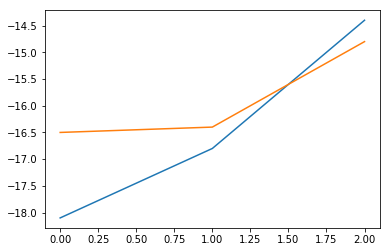

In [23]:
mw_vmag = satellite_data_A['vmag']
m31_vmag = satellite_data_B['vmag']
plt.plot(np.sort(mw_vmag))
plt.plot(np.sort(m31_vmag))

In [ ]:
a = np.array([ 192. , 209. , 181.])
np.sqrt(np.sum(a**2))